<a href="https://www.kaggle.com/code/juancamilo0218/dataset-titanic?scriptVersionId=271398269" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [22]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic-machine-learning-from-disaster/train.csv
/kaggle/input/titanic-machine-learning-from-disaster/test.csv


In [23]:
import matplotlib.pyplot as plt
import joblib
from sklearn.model_selection import cross_val_score, KFold, train_test_split
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_curve, auc

In [24]:
path_1 = "/kaggle/input/titanic-machine-learning-from-disaster/train.csv"
path_2 = "/kaggle/input/titanic-machine-learning-from-disaster/test.csv"
train = pd.read_csv(path_1)
test = pd.read_csv(path_2)


In [25]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [26]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
PassengerId,891.0,446.000000,257.353842,1.00,223.5000,446.0000,668.5,891.0000
Survived,891.0,0.383838,0.486592,0.00,0.0000,0.0000,1.0,1.0000
Pclass,891.0,2.308642,0.836071,1.00,2.0000,3.0000,3.0,3.0000
Age,714.0,29.699118,14.526497,0.42,20.1250,28.0000,38.0,80.0000
SibSp,891.0,0.523008,1.102743,0.00,0.0000,0.0000,1.0,8.0000
Parch,891.0,0.381594,0.806057,0.00,0.0000,0.0000,0.0,6.0000
Fare,891.0,32.204208,49.693429,0.00,7.9104,14.4542,31.0,512.3292


In [27]:
train.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [28]:
ytrain = train['Survived']
train = train.drop(['Name', 'Ticket', 'PassengerId','Cabin', 'Survived'], axis=1)

In [29]:
train.columns

Index(['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked'], dtype='object')

In [30]:
encoder_ = OrdinalEncoder()
lista = ["Sex", "Embarked"]
train[lista]= encoder_.fit_transform(train[lista])
imputer_ = SimpleImputer(strategy='median')
train[['Age','Embarked']] = imputer_.fit_transform(train[['Age','Embarked']])

In [31]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    891 non-null    int64  
 1   Sex       891 non-null    float64
 2   Age       891 non-null    float64
 3   SibSp     891 non-null    int64  
 4   Parch     891 non-null    int64  
 5   Fare      891 non-null    float64
 6   Embarked  891 non-null    float64
dtypes: float64(4), int64(3)
memory usage: 48.9 KB


In [32]:
train.isnull().sum()

Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64

In [34]:
# Seleccionar columnas de interés
features = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']
target = 'Survived'

# Separar variables independientes (X) y dependiente (y)
x = train[features]
ytrain = train[target]

# Escalar los datos (KNN es sensible a la escala)
scaler = StandardScaler()
x_scaled = scaler.fit_transform(x)

# Definir el modelos
# === Definir los 5 modelos ===
models = {
    'Naive Bayes': GaussianNB(),
    'QDA': QuadraticDiscriminantAnalysis(),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'SVM': SVC(kernel='rbf', C=1, probability=True, random_state=42),
    'KNN': KNeighborsClassifier(n_neighbors=5)
}

# Definir la validación cruzada (5 particiones)
kf = KFold(n_splits = 5, shuffle = True, random_state = 42)

results = {}
for name, model in models.items():
    scores = cross_val_score(model, x_scaled, ytrain, cv=kf, scoring='accuracy')
    results[name] = scores
    print(f"{name}: {scores.mean():.4f} ± {scores.std():.4f}")


KeyError: 'Survived'

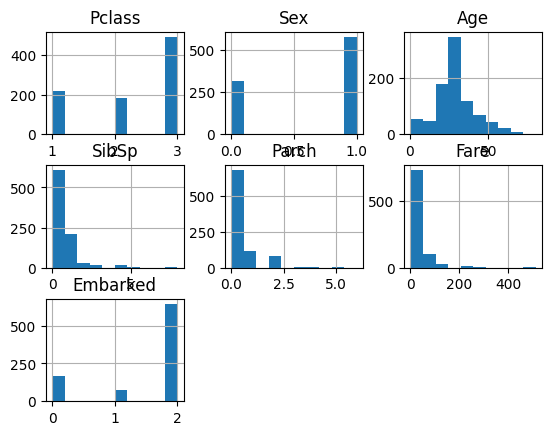

In [35]:
train.hist()
plt.show()

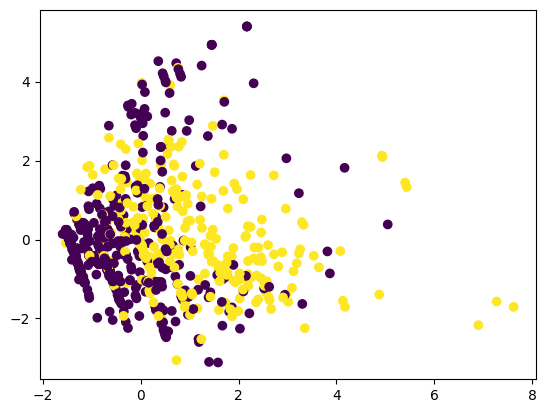

In [36]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

sca_ = StandardScaler()
red_ = PCA(n_components = 2)
ztrain = red_.fit_transform(sca_.fit_transform(train))
ztrain.shape
plt.scatter(ztrain[:,0],ztrain[:,1],c=ytrain)

In [37]:
import cudf, cupy as cp
from cuml.manifold import UMAP
import matplotlib.pyplot as plt

print("cudf:", cudf.__version__)

cudf: 25.02.02


In [38]:
!nvidia-smi

Mon Oct 27 14:17:34 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   43C    P8             10W /   70W |       3MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [39]:
train

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,1.0,22.0,1,0,7.2500,2.0
1,1,0.0,38.0,1,0,71.2833,0.0
2,3,0.0,26.0,0,0,7.9250,2.0
3,1,0.0,35.0,1,0,53.1000,2.0
4,3,1.0,35.0,0,0,8.0500,2.0
...,...,...,...,...,...,...,...
886,2,1.0,27.0,0,0,13.0000,2.0
887,1,0.0,19.0,0,0,30.0000,2.0
888,3,0.0,28.0,1,2,23.4500,2.0
889,1,1.0,26.0,0,0,30.0000,0.0


In [40]:
from cuml.manifold import UMAP
import time

umap = UMAP(
    n_neighbors=500,     # más pequeño => preserva estructura local
    min_dist=0.2,       # menor => clusters más compactos
    n_components=2,     # proyección 2D
#    metric="euclidean", # métrica por defecto
#    init="spectral",    # inicialización estable
#    random_state=42
)
sca_ = StandardScaler()
z = umap.fit_transform(sca_.fit_transform(train))
z = np.asarray(z)
z

[2025-10-27 14:17:45.101] [CUML] [info] Building knn graph using brute force


array([[ 7.2548695, -2.0312738],
       [ 2.137907 , -3.9898186],
       [-0.2291069, -2.1216812],
       ...,
       [ 1.7038031, -2.5560665],
       [ 2.6766796, -5.0929127],
       [ 4.269453 , -5.6533337]], dtype=float32)

In [41]:
ytrain1 = np.asarray(ytrain)
ytrain1

array([0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1,
       1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1,
       1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1,
       1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0,
       0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0,
       1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0,
       1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0,
       0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0,
       1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1,

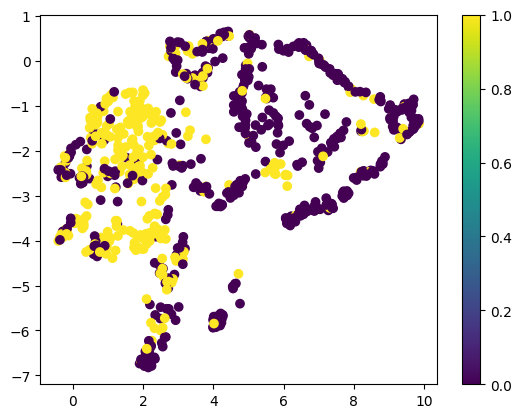

In [42]:
plt.scatter(z[:,0],z[:,1],c=ytrain1)
plt.colorbar()
plt.show()

In [43]:
#Particion entrenamiento y evaluación
# Tamaño Xtrain 70%, Tamaño Xtest 30%
Xtrain, Xtest, ytrain,ytest = train_test_split(train,ytrain,test_size=0.3, random_state=123)
Xtrain.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
416,2,0.0,34.0,1,1,32.5000,2.0
801,2,0.0,31.0,1,1,26.2500,2.0
512,1,1.0,36.0,0,0,26.2875,2.0
455,3,1.0,29.0,0,0,7.8958,0.0
757,2,1.0,18.0,0,0,11.5000,2.0


In [44]:
#%% Escoger modelo por gridsearchCV utilizando pipeline
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV


#se crean listas de steps (pipelines)
steps=[[('nor', MinMaxScaler()),
        ('cla', KNeighborsClassifier())], #Pipeline1
       [('nor',  MinMaxScaler()),
        ('cla', SGDClassifier())],#Pipeline2
        [('nor',MinMaxScaler()),
         ('cla', SVC())]#Pipeline3
      ]

parameters = [{
              'cla__n_neighbors': [1, 3, 5, 9],#Pipeline1 - hyperparametros
              },
              {
              'cla__alpha': [1e-3,1e-2,1e-1,1,10,1e2,1e3],#Pipeline2 - hyperparametros
              },
              {
             'cla__C': [1,10,1e2,1e3,1e4],
             'cla__gamma': [1e-3, 1e-2, 1e-1,1, 10]    #Pipeline2 - hyperparametros
             }
             ]

label_models = ['MinMax_Logistic','MinMax_SGD', 'MinMax_SVCrbf']

models = []
filename = 'results/lfw_models'

# Crear la carpeta si no existe
os.makedirs('results', exist_ok=True)

for i in range(len(steps)): # recorrer modelos según lista pipeline
    print('modelo %d/%d' % (i+1,len(steps)))
    grid_search = GridSearchCV(Pipeline(steps[i]), parameters[i], n_jobs=-1,cv=5,
                                scoring='accuracy',refit= True,verbose=10)#gridsearch para modelo i
    grid_search.fit(Xtrain, ytrain)
    #mejor modelo entrenado
    models += [grid_search] #guardar modelos
    joblib.dump(models,filename+".pkl")

modelo 1/3
Fitting 5 folds for each of 4 candidates, totalling 20 fits
modelo 2/3
Fitting 5 folds for each of 7 candidates, totalling 35 fits
modelo 3/3
Fitting 5 folds for each of 25 candidates, totalling 125 fits


In [45]:
ind = models[2].cv_results_['mean_test_score'].argmax()#encontrar rendimiento más alto sobre CV del gridsearch en test
models[i].cv_results_['mean_test_score'][i]

0.7817548387096774

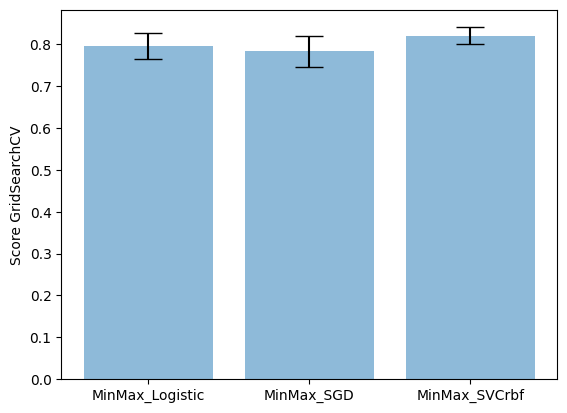

['MinMax_Logistic', 'MinMax_SGD', 'MinMax_SVCrbf']
[[0.795 0.783 0.82 ]
 [0.031 0.037 0.02 ]]


In [46]:
#recorrer modelos
bars_ = np.zeros((2,len(models)))#arreglo de barras para graficar mejores modelos en promedio con std
for i in range(len(models)):
  ind = models[i].cv_results_['mean_test_score'].argmax()#se determina el mejor score de clasificación
  bars_[0,i] = models[i].cv_results_['mean_test_score'][ind]#guardar score promedio del mejor modelo
  bars_[1,i] = models[i].cv_results_['std_test_score'][ind]#guardar std del mejor modelo

plt.bar(np.arange(len(models)), bars_[0], yerr=bars_[1], align='center', alpha=0.5, ecolor='black', capsize=10)
plt.ylabel('Score GridSearchCV')
plt.xticks(np.arange(len(models)))
plt.gca().set_xticklabels(label_models)
plt.show()

print(label_models)
print(np.round(bars_,3))

Evaluando modelo MinMax_Logistic (1/3)


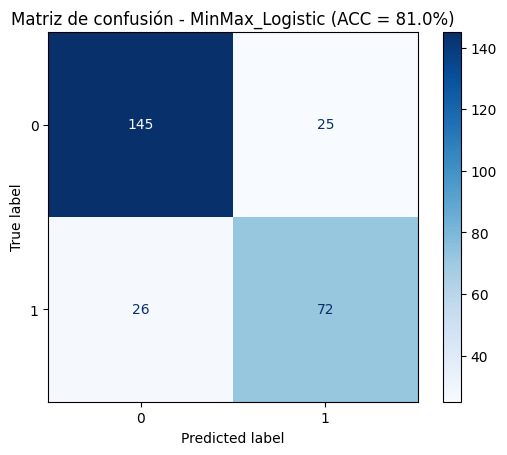

              precision    recall  f1-score   support

           0       0.85      0.85      0.85       170
           1       0.74      0.73      0.74        98

    accuracy                           0.81       268
   macro avg       0.80      0.79      0.79       268
weighted avg       0.81      0.81      0.81       268

Evaluando modelo MinMax_SGD (2/3)


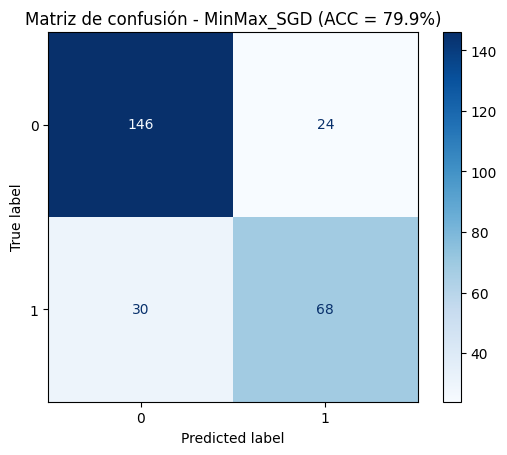

              precision    recall  f1-score   support

           0       0.83      0.86      0.84       170
           1       0.74      0.69      0.72        98

    accuracy                           0.80       268
   macro avg       0.78      0.78      0.78       268
weighted avg       0.80      0.80      0.80       268

Evaluando modelo MinMax_SVCrbf (3/3)


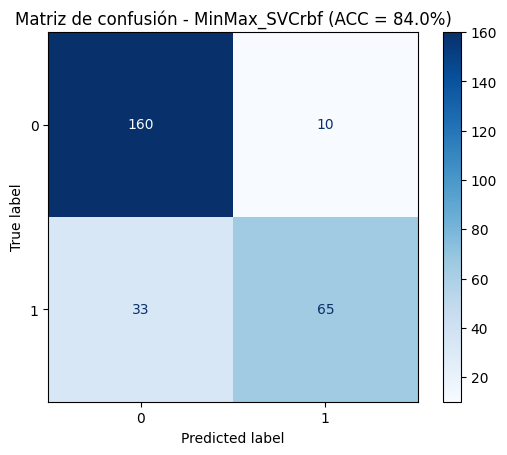

              precision    recall  f1-score   support

           0       0.83      0.94      0.88       170
           1       0.87      0.66      0.75        98

    accuracy                           0.84       268
   macro avg       0.85      0.80      0.82       268
weighted avg       0.84      0.84      0.83       268



In [47]:
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay, classification_report


#%% Evaluar sobre Xtest
my_model_loaded = joblib.load(filename + ".pkl")
path_img = ''

for i in range(len(my_model_loaded)):
    print('Evaluando modelo %s (%d/%d)' % (label_models[i], i + 1, len(my_model_loaded)))

    # Predicción
    ytest_e = my_model_loaded[i].best_estimator_.predict(Xtest)
    
    # Exactitud
    acc = accuracy_score(ytest, ytest_e)
    
    # Matriz de confusión
    ConfusionMatrixDisplay.from_predictions(ytest, ytest_e, cmap='Blues')
    plt.title(f'Matriz de confusión - {label_models[i]} (ACC = {100 * acc:.1f}%)')
    plt.show()
    
    # Reporte de clasificación
    cr = classification_report(ytest, ytest_e)
    print(cr)


Evaluando modelo MinMax_Logistic (1/3)


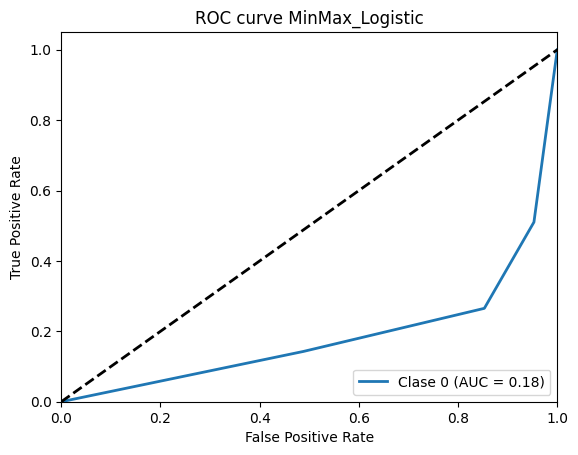

Evaluando modelo MinMax_SGD (2/3)


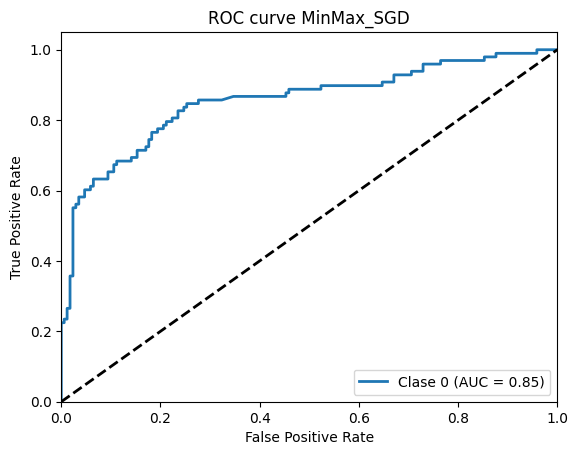

Evaluando modelo MinMax_SVCrbf (3/3)


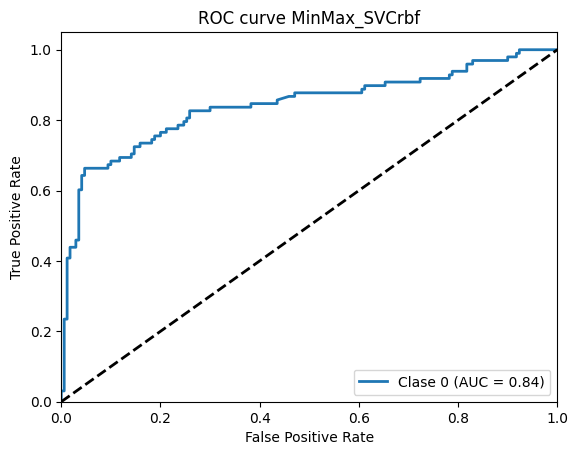

[CV 3/5; 1/4] START cla__n_neighbors=1..........................................
[CV 3/5; 1/4] END ...........cla__n_neighbors=1;, score=0.768 total time=   0.0s
[CV 3/5; 2/4] START cla__n_neighbors=3..........................................
[CV 3/5; 2/4] END ...........cla__n_neighbors=3;, score=0.784 total time=   0.0s
[CV 1/5; 3/4] START cla__n_neighbors=5..........................................
[CV 1/5; 3/4] END ...........cla__n_neighbors=5;, score=0.784 total time=   0.0s
[CV 5/5; 3/4] START cla__n_neighbors=5..........................................
[CV 5/5; 3/4] END ...........cla__n_neighbors=5;, score=0.774 total time=   0.0s
[CV 4/5; 4/4] START cla__n_neighbors=9..........................................
[CV 4/5; 4/4] END ...........cla__n_neighbors=9;, score=0.798 total time=   0.0s
[CV 4/5; 1/7] START cla__alpha=0.001............................................
[CV 4/5; 1/7] END .............cla__alpha=0.001;, score=0.790 total time=   0.0s
[CV 5/5; 1/7] START cla__alp

In [48]:
from sklearn.preprocessing import label_binarize

classes = np.unique(ytrain)
ytrain_b = label_binarize(ytrain, classes=classes)
ytest_b = label_binarize(ytest, classes=classes)

def roc_multiclass(y_true, y_score):
    # Asegurar que sean 2D
    if y_score.ndim == 1:
        y_score = y_score.reshape(-1, 1)
    if y_true.ndim == 1:
        y_true = y_true.reshape(-1, 1)

    n_classes = y_true.shape[1]
    fpr, tpr, roc_auc = dict(), dict(), dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    return roc_auc, fpr, tpr, n_classes


def roc_auc_mc(roc_auc, fpr, tpr, n_classes, title, path_img):
    plt.figure()
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], lw=2, label='Clase %d (AUC = %0.2f)' % (i, roc_auc[i]))
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.show()

for i in range(len(my_model_loaded)):
    print('Evaluando modelo %s (%d/%d)' % (label_models[i],i+1,len(my_model_loaded)))
    #debe calcularse la funcion de decision o el posterior de la probabilidad
    model = my_model_loaded[i].best_estimator_
    if hasattr(model, "decision_function"):
        ytest_score = model.decision_function(Xtest)
    else:
        ytest_score = model.predict_proba(Xtest)

    roc_auc, fpr, tpr, n_classes = roc_multiclass(ytest_b,ytest_score)
    roc_auc_mc(roc_auc,fpr,tpr,n_classes,'ROC curve ' + label_models[i],path_img)